In [8]:
# %load /Users/wayment/ipynb_defaults.py
%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
import sys
from scipy.stats.mstats import winsorize
from scipy.stats import gaussian_kde

def estimate_mode(arr):
    arr = arr[~np.isnan(arr)]
    kde = gaussian_kde(arr)
    x_range = np.linspace(min(arr), max(arr), 1000)
    kde_values = kde(x_range)
    max_density_index = np.argmax(kde_values)
    max_density_location = x_range[max_density_index]
    return max_density_location

CURRDATE='02aug2025'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [18]:
d = pd.read_excel('metadata_09dec2024.xlsx',sheet_name='RelaxDB_metadata')
d=d[['entry_ID','field_strength','sequence','seq length','Filter',
     'lit_tm','missing_peaks','Curation source','Classification','Temperature (K)']]
d_manual = d.loc[~d['Curation source'].isin(['BMRB','BMRB+curated NOEs'])]

In [19]:
# Doing row by row because some entry_ID have more than 1 field.

dct={'entry_ID': [], 'field_strength': [], 'R1': [], 'R2': [], 'R1_err': [], 'R2_err': [], 'NOE':[], 'NOE_err':[]}

for _, row in d_manual.iterrows():
    IND=row['entry_ID']
    if isinstance(row['field_strength'],str):
        fields = row['field_strength'].split(' ')
        for field in fields:
            tmp = pd.read_excel('../manually_curated_datasets/%s_%sMHz.xlsx' % (IND, field))
            tmp = tmp.dropna(subset=['seqpos'])
            
            dct['entry_ID'].append(IND)
            dct['field_strength'].append(field)

            for MET in ['R1','R2','R1_err','R2_err','NOE','NOE_err']:
                vec = np.ones(row['seq length'])*np.nan
                if MET in tmp.columns:
                    for _, r in tmp.iterrows():
                        vec[round(r['seqpos'])-1] = r[MET]
                else:
                    print(IND, MET)

                dct[MET].append(np.asarray(vec))
          
    else:
        tmp = pd.read_excel('../manually_curated_datasets/%s.xlsx' % IND)
        tmp = tmp.dropna(subset=['seqpos'])
        
        dct['entry_ID'].append(IND)
        dct['field_strength'].append(row['field_strength'])

        for MET in ['R1','R2','R1_err','R2_err','NOE','NOE_err']:
            vec = np.ones(row['seq length'])*np.nan
            if MET in tmp.columns:
                for _, r in tmp.iterrows():
                    vec[round(r['seqpos'])-1] = r[MET]
            else:
                print(IND, MET)
                    
            dct[MET].append(np.asarray(vec))
            
df = pd.DataFrame.from_records(dct)
df = df.fillna(value=np.nan)

for col in df.columns:
    if isinstance(df[col].iloc[0],list):
        df[col] = [np.asarray(x,dtype=float) for x in df[col]]
        
print('len df:', len(df))

# Get BMRB data

bmrb = pd.read_json('BMRB_subset_RelaxDB_20jan2025.json.zip')

for col in bmrb.columns:
    if isinstance(bmrb[col].iloc[0],list):
        bmrb[col] = [np.asarray(x,dtype=float) for x in bmrb[col]]


print('len BMRB:', len(bmrb))
df = pd.concat([df, bmrb[['entry_ID','R1','R2','NOE','R1_err','R2_err','NOE_err','field_strength']]])
df = df.reset_index()
df['orig_R1_err'] = df['R1_err'].copy()
df['orig_R2_err'] = df['R2_err'].copy()

print('len df merged:', len(df))
print('N unique entries:', len(df.entry_ID.unique()))

len df: 104
len BMRB: 90
len df merged: 194
N unique entries: 160


In [20]:
def calc_R2_R1(row):
    R2_R1 = row['R2']/row['R1']        
    err = np.sqrt((row['R1_err']/row['R1'])**2 +(row['R2_err']/row['R2'])**2)*row['R2']/row['R1']
    return R2_R1, err

df['field_strength'] = df.apply(lambda row: int(row['field_strength']), axis=1)
df['field_strength_tesla'] = df.apply(lambda row: int(row['field_strength'])/42.576, axis=1)

# merge metadata in
df = df.merge(d[['entry_ID','sequence','missing_peaks','lit_tm','Filter',
                 'Curation source','Classification', 'seq length','Temperature (K)']], on='entry_ID',how='left')

print(len(df))

df[['R2_R1', 'R2_R1_err']] =df.apply(lambda row: calc_R2_R1(row), axis=1, result_type='expand')
df['NOE'] = [np.clip(x,0,1) for x in df['NOE']]

out = pd.read_json('HYDRONMR_output_10jan2025.json')
#out = pd.read_json('HYDRONMR_output_02aug2025.json') has diff OMP model

out['field_strength'] = out.apply(lambda row: int(row['field_strength']), axis=1)

for col in out.columns:
    if isinstance(out[col].iloc[0],list):
        out[col] = [np.asarray(x,dtype=float) for x in out[col]]

t = df.merge(out[['entry_ID','field_strength','raw_R2_R1_pred']], how='left',left_on=['entry_ID','field_strength'],right_on=['entry_ID','field_strength'])


194


In [21]:
t.to_json('RelaxDB_pre_fitting_02aug2025.json.zip')

In [52]:
from scipy.optimize import minimize

def fit_calculated_R2R1(row):
    # if row['entry_ID'] == 15521:
    #     DEBUG=True
    # else:
    DEBUG=False
    
#     print(row['entry_ID'])
#     print(np.nanmean(row['raw_R2_R1_pred']))
    
    def objective(C):
        est_mean = estimate_mode(row['R2_R1'])
        ma = np.abs(row['R2_R1'] - est_mean) < np.nanstd(row['R2_R1'])
        diff = (row['R2_R1'][ma] - C*row['raw_R2_R1_pred'][ma])
        return np.nanmean(np.square(diff))

    if DEBUG:
        print(estimate_mode(row['R2_R1']))
    C = estimate_mode(row['R2_R1'])/np.nanmean(row['raw_R2_R1_pred']) 
    
    result = minimize(objective, C)
    optimal_C = result.x[0]
        
    if DEBUG:
        print(optimal_C)
    
    scaled_R2_R1_pred = row['raw_R2_R1_pred'] * optimal_C
    
    dR2R1 = row['R2_R1'] - scaled_R2_R1_pred
    dR2 = dR2R1 * row['R1']
    dR2_err = np.sqrt((row['R1_err']/row['R1'])**2 + (row['R2_R1_err']/row['R2_R1'])**2) * np.abs(dR2)
    net_dR2 = np.nanmean(np.abs(dR2))

    return scaled_R2_R1_pred, dR2R1, dR2, dR2_err, net_dR2

# merge in HYDRONMR calculations
t[['scaled_R2_R1_pred','dR2R1','dR2','dR2_err','net_dR2']] = t.apply(lambda row: fit_calculated_R2R1(row),axis=1,result_type='expand')

t['dR2R1_err'] = t['R2_R1_err']
t['std_dR2_R1'] = t.apply(lambda row: np.nanstd(np.abs(row['scaled_R2_R1_pred'] - row['R2_R1'])), axis=1)
t['std_dR2'] = t.apply(lambda row: np.nanstd(row['dR2']), axis=1)

def assign_labels(row):

    label_list = ''
    NOE_cutoff = 0.65
    
    m=estimate_mode(row['dR2R1'])
    s = np.nanstd(row['dR2R1'])
    
#     m=estimate_mode(row['dR2'])
#     s = np.nanstd(row['dR2'])
        
    C = np.max([m+s,1])
    if row['Filter']==1:
        print(row['entry_ID'], row['field_strength'], m+s)
    
    dR2_not_labelled=[]
    for i, val in enumerate(row['sequence']):
        #x = row['dR2'][i] 
        x= row['dR2R1'][i]
        
        if val=='P':
            label_list+='p'
        elif row['missing_peaks'][i] =='.':
            label_list+='.'
        elif x > C and (row['NOE'][i] > NOE_cutoff or pd.isna(row['NOE'][i])):
            label_list+='^'
        elif x > C and row['NOE'][i] <= NOE_cutoff:
            label_list +='b'
        elif row['NOE'][i] <= NOE_cutoff:
            label_list+='v'

        elif np.isnan(row['raw_R2_R1_pred'][i]):
            label_list +='t' # not estimated in rigid calc
        elif np.isnan(row['dR2'][i]) and row['missing_peaks'][i] == 'A':
            label_list+='x' # peak present but no R1/R2 data
            
        else:
            label_list+='A'
            dR2_not_labelled.append(np.abs(x))
            
    if row['entry_ID']=='MK12': #from peter wright model-free
        label_list='...pppAAAbb^^vbvxbvvvbb.vbvvbbApxxxv.vxxxbvA^bvvxbbvxxxx^vb^pAbxxxxvvv............vAAvbvvv.xxApvvvxbvbbx.....pvvxvv^xbxvxvvxvbvxxvAbv.b.....xxx.xxvvxx.....pxvbxbvbvbbvvxx.vb.vvxxvxvvxxAbx..xx..px.x.....xxx^.xb..vxxxx^..bbvAv....x..x^vxxxx..bxvxppbvbxbv^.....vvvvvvvpvvvvvxbbvxbxvvbpvAAvvv.x..x^vxxvvvbxvvx^vxpvxbvxbvxvvvpvvvvbbbvvAvvvvvvvxvxxxxxxvxvvxxppxxxxxxxxxxxpx'
        assert len(label_list) == len(row['sequence'])
        
    return label_list, C, m, m+s, np.mean(dR2_not_labelled)

t[['label','dR2R1_cutoff','dR2R1_m','dR2R1_m+s','dR2R1_not_labelled']] = t.apply(lambda row: assign_labels(row),axis=1,result_type='expand')

for x in [25,50,70,100]:
    print(np.percentile(t['net_dR2'],x))
    
t.to_json(f'RelaxDB_all_field_strengths_{CURRDATE}.json.zip')
# Use max field strength for labels
dd = t.sort_values('field_strength',ascending=False)
dd = dd.drop_duplicates('entry_ID')

dd.index = dd['entry_ID']
dd = dd.drop(columns='index')
print(len(dd))
dd.to_json(f'RelaxDB_161x_UNFILTERED_{CURRDATE}.json.zip')

dd = dd.loc[dd.Filter==1]
print(len(dd))
dd.index = [str(x) for x in dd.index]
dd.to_json(f'RelaxDB_133x_{CURRDATE}.json.zip')

ACRIIA4 800 3.673000612430913
ATS 700 6.305403129591048
CDK3 600 1.910906313210269
CSPA 500 1.0283363777118568
CXCL8 600 0.26977454565667836
CXCL8 800 0.6683633419033967
DR1885 500 0.7441921387834755
FSIB 700 2.211861470505528
IL13 600 0.9347134396269726
ORC2WH 700 2.0945468965102956
PCF11 700 3.3088069552611747
PI3KSH2 700 2.538655504421021
PLEXINB1 600 2.5076355092833613
PLEXINB1 800 5.062466785658866
PSD1 600 1.23528355556731
RNASE 600 0.970480521668742
UBE2G1 800 7.519792639238946
CD9K 500 0.20228621405108332
ATFKR 500 1.1801482061266089
TRX 500 0.33134699296313863
GPIIA 500 0.3508055849541238
IL4 500 1.290832287412335
CMTIV 500 0.177106036092199
LYSZ 500 0.29373493267450645
CHEAYBD 500 0.751978589124536
CHEA 500 0.5847875603405006
HMG1A 500 1.7999392780880454
HMG1A 600 2.2199399962043427
HMG1B 500 0.9566334128043513
EGLC 500 0.27120115403534273
EGLC 600 0.3125373792145411
RNASEHI 600 2.292816296886083
IL1B 600 2.6451249616811667
VL 600 1.5817367441754855
ACBP 600 0.699005044601670

/Users/wayment/opt/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wayment/opt/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


160
133


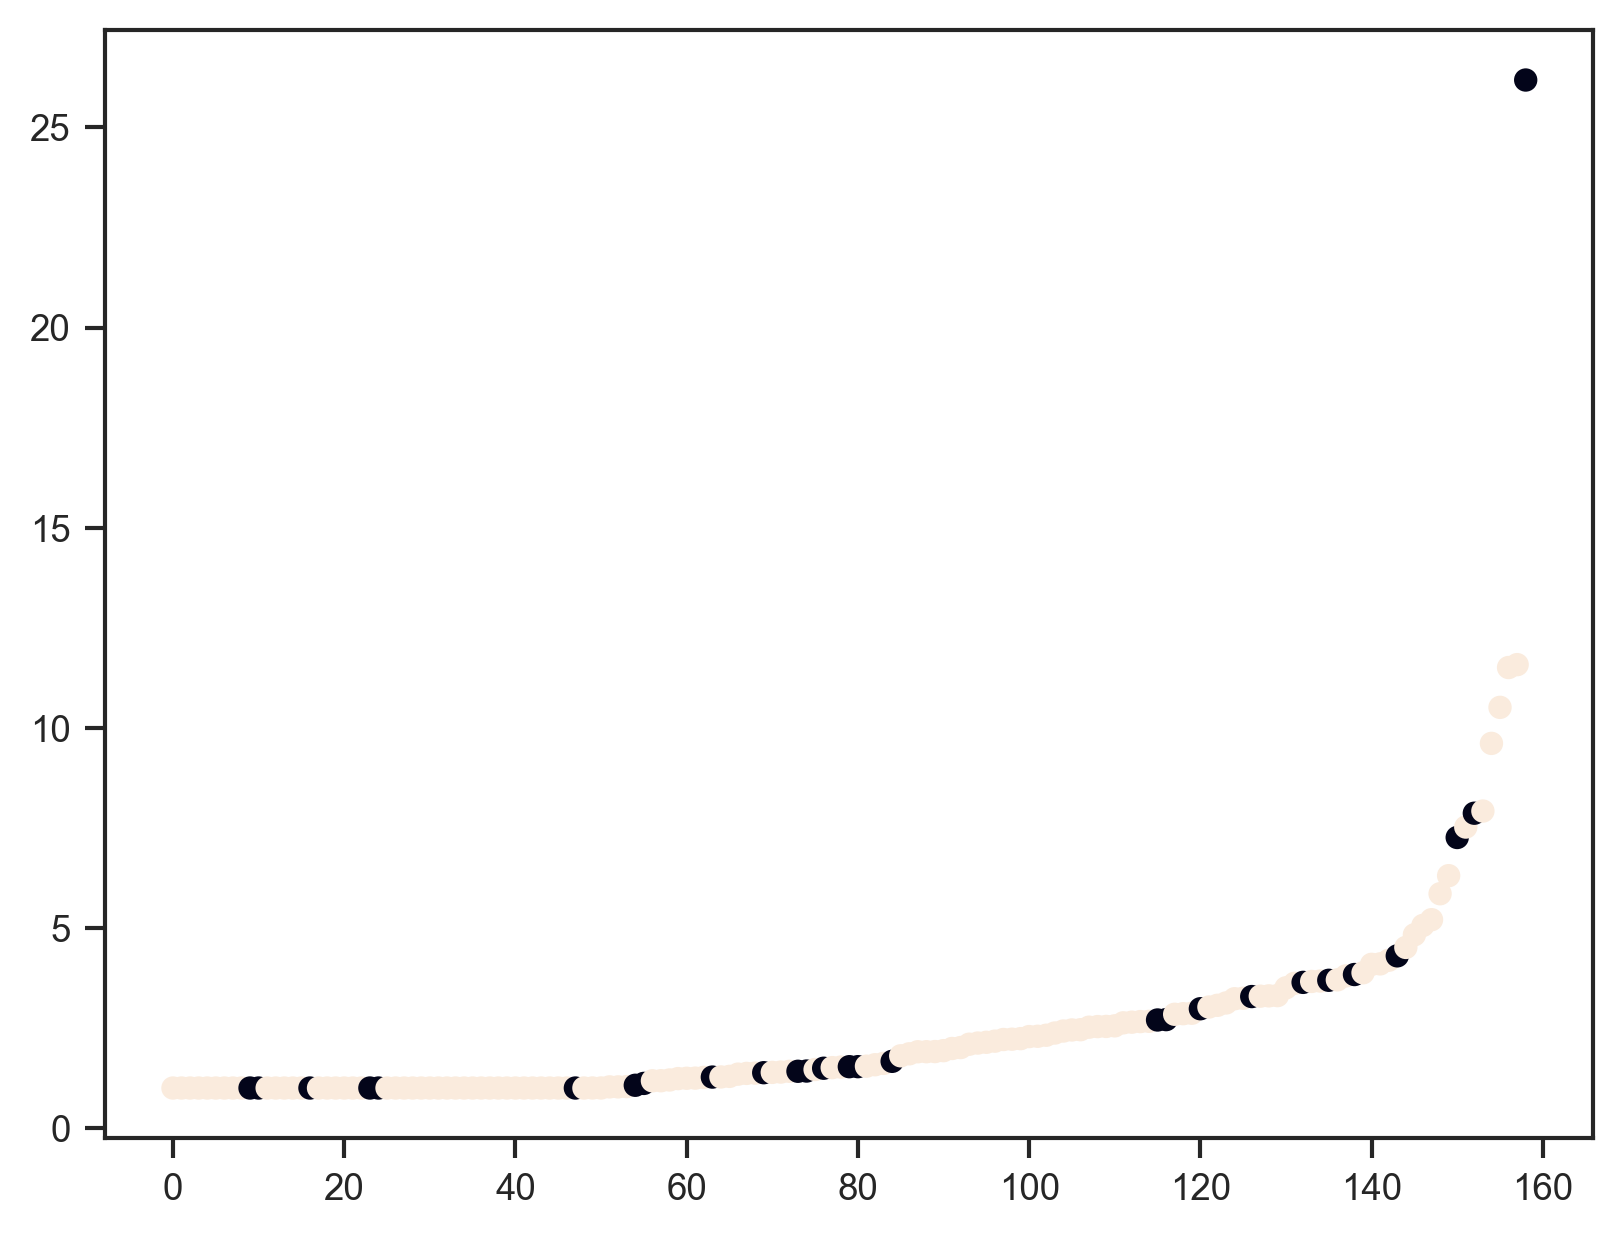

In [53]:
all_datasets = pd.read_json(f'RelaxDB_161x_UNFILTERED_{CURRDATE}.json.zip')
all_datasets = all_datasets.loc[all_datasets.entry_ID!='MK12']

all_datasets= all_datasets.sort_values('dR2R1_cutoff')
scatter(range(len(all_datasets)), all_datasets['dR2R1_cutoff'], c=all_datasets['Filter'])


In [54]:
all_datasets.iloc[-1]

NOE                     [None, 0.7718, 0.853, 0.7109000000000001, None...
NOE_err                 [None, 0.004200000000000001, 0.0103, 0.0019, N...
R1                      [None, 0.6131207998, None, 0.9099180999, None,...
R1_err                  [None, 0.0284193339, None, 0.0396588504, None,...
R2                      [None, 34.2700479781, None, 20.4373594932, Non...
R2_err                  [None, 1.3740903405, None, 0.4594542294, None,...
entry_ID                                                           ISDHN3
field_strength                                                        800
orig_R1_err             [None, 0.0284193339, None, 0.0396588504, None,...
orig_R2_err             [None, 1.3740903405, None, 0.4594542294, None,...
field_strength_tesla                                            18.789929
sequence                LTDLQEAHFVVFESEENSESVMDGFVEHPFYTATLNGQKYVVMKTK...
missing_peaks           AAAAAAAAAAAAAAAAAAAAAAAAAAAApAAAAAAAAAAAAAAAAA...
lit_tm                                

In [48]:
# write pkl files for model evaluation

import os
os.makedirs(f'relaxdb_data_{CURRDATE}',exist_ok=True)
import pickle
for _, row in dd.iterrows():
    with open(f"relaxdb_data_{CURRDATE}/{row['entry_ID']}.pkl",'wb') as f:
        pickle.dump({'entry_ID': row['entry_ID'],'sequence': row['sequence'],'label': row['label']},f)

# write fasta for train/test split

# with open('RelaxDB_134x_09dec2024.fasta','w') as f:
#     for _, row in dd.iterrows():
#         f.write(f">{row['entry_ID']}\n{row['sequence']}\n")

KeyError: 'labels'